This program uses the advection equation to propagate modes on a uniform grid `nt` timesteps using an RK solver and a matrix exponential time propagation and assesses their amplitude error against the Fourier rotation matrix propagated solution.  It then performs a Von Neumman analysis on the RK results tested against the Fourier propagation.

In [1]:
import os.path
from scipy import *
import scipy as sp
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import math as math
from math import factorial as fact

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

This cell takes all of the input parameters.

In [2]:
# Grid parameters.
nh_min = 64
refRatio = 2
cfInter = int(nh_min / refRatio)

# Time integration parameters.
CFL = np.sqrt(0.5)
nt = 1
deriv = 'U'
RK = 1
order = 1

# Waveform parameters.
x_0 = 0.
x_1 = float(cfInter) / float(nh_min)

# Physical parameters.
L = 1e-3
locs = []#x_1]
epsilons_r = [1]#, 11.68]
mus_r = [1]#, 0.99837]

# Pseudo-FFT parameters.
Hans = False

This cell instantiates the Grid and the Physics objects.

In [3]:
omega = BT.Grid(nh_min)
# finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
# omega.AddPatch(refRatio, finehalf)
physics = BT.PhysProps(omega, epsilons_r, mus_r, locs, L)
c = physics.cVec[0]
waves = WT.MakeWaves(omega)


In [4]:
def SolverPhaseTheoretical(omega, RK, deriv, CFL):
    nh_max = omega.nh_max
    ks = np.arange((nh_max / 2) + 1)
    theta = (2 * np.pi * ks) / nh_max
    if (deriv == 'U'):
        print('Upwind', RK)
        x = CFL * (np.exp(1j * theta) - 1) # CFL * (1 - np.exp(-1j * theta))
    else:
        x = 0.5 * CFL * (np.exp(1j * theta) - np.exp(-1j * theta))
    coefs = np.arange(RK + 1)[::-1]
    coefs = sp.special.factorial(coefs)**-1
    # coefs[1::2] = -coefs[1::2]
    p = np.poly1d(coefs)
    amps = p(x)
    phases = np.arctan(np.imag(amps) / np.real(amps))
    return ks, phases

In [5]:
def PhaseError(omega, theoreticalIn, actualIn, tol = 1e-20, printOut = False):
    # Check size of theoretical and actual.
    nh = omega.nh_max
    numKs = int((nh / 2) + 1)
    actual = np.round(actualIn, 15)
    theoretical = np.round(theoreticalIn, 15)
    error = np.zeros(numKs, float)
    error[0] = 1 - np.sqrt(((actual[0] ** 2) + tol) / ((theoretical[0]**2) + tol))
    error[::-1][0] = 1 - np.sqrt(((actual[::-1][0] ** 2) + tol) / ((theoretical[::-1][0]**2) + tol))
    error[1:-1] = 1 - (np.arctan(actual[1::2][:-1] / actual[::2][1:]) + tol) / (np.arctan(theoretical[1::2][:-1] / theoretical[::2][1:]) + tol)
    indices = np.argwhere(np.isnan(error))
    error[indices] = 0
    ks = np.arange(numKs)
    if (printOut):
        print('Actual:')
        print(actual)
        print('Theoretical:')
        print(theoretical)
        print('Error:')
        print(error)
        print('')
    return ks, error

In [6]:
# ----------------------------------------------------------------------------------------------------------------
# Function: ModeProp
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function creates the Fourier rotation matrix.
# ----------------------------------------------------------------------------------------------------------------
# Inputs:
#
# omega                   Grid                    Object containing all grid attributes
# physics                 PhysProps               Object containing all physical specifications of the space
# nt                      int                     Number of timesteps
# CFL                     float                   CFL condition
# deriv                   string                  Type of discrete derivative operation
# RK                      int                     Order of RK scheme
# order                   int                     Order of the polynomial interpolation on the derivative operator
# ----------------------------------------------------------------------------------------------------------------
# Outputs:
#
# propFCoefs              array                   Fourier rotation matrix
# ----------------------------------------------------------------------------------------------------------------

In [7]:
def ModeProp(omega, physics, nt, CFL, deriv, RK, order):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    
    # GET RID OF THIS ULTIMATELY!
    TimeIntegratorFunc, DiffFunc = TT.SolverSwitch(deriv, RK)

    cMat = physics.cMat
    c = cMat[0, 0] # THIS IS KIND OF JANK, AND YOU SHOULD PROBABLY CHANGE IT.
    t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt)
    derivMat = OT.SpaceDeriv(omega, order, deriv)
    spatOp = -cMat @ derivMat
    strings = omega.strings
    timePropOp = LA2.expm(t * spatOp)
    waves = WT.MakeWaves(omega)
    omegaF = BT.Grid(nh_max)
    wavesF = WT.MakeWaves(omegaF)
    restrictOp = GTT.CoarsenOp(omega)
    nullspace = OT.FindNullspace(omega, waves)
    
    op = -cMat @ OT.SpaceDeriv(omega, order, deriv)
    
    FCoefsF = np.eye(nh_max)# [:, :nh_min]
    FCoefs = np.zeros((degFreed, nh_max), float)
    propFCoefs = np.zeros((degFreed, nh_max), float)
    solvFCoefs = np.zeros((degFreed, nh_max), float)
    exTimeCoefs = np.zeros((degFreed, nh_max), float)
    
    for k in range(nh_max):
        waveformF = wavesF @ FCoefsF[:, k] # nullspace[:, k]
        propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c* t) # This is wrong, but it's producing the right results.
        waveform = restrictOp @ waveformF
        FCoefs[:, k] = FFTT.FourierCoefs(waves @ nullspace, waveform)

        # Fill solvFCoefs with coefs for all RK propagated modes.
        solvFCoefs[:, k] = ST.RungeKutta(omega, physics, waves @ nullspace, waveform, nt, CFL, RK, op) # TimeIntegratorFunc(omega, physics, waves @ nullspace, waveform, nt, CFL, op) # (omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
        exTimeForm = timePropOp @ waveform
        exTimeCoefs[:, k] = FFTT.FourierCoefs(waves @ nullspace, exTimeForm)
        if (k == nh_max - 1):
            print('ct =', c*t)
            print('')
            print(np.round(propFCoefs, 10))
            print('BREAK')
            print(np.round(exTimeCoefs, 10))
            print('timePropOp:')
            print(np.round(timePropOp, 10))
            print('Waveform:')
            print(np.round(waveform, 10))
    propFCoefs = nullspace @ propFCoefs
    solvFCoefs = nullspace @ solvFCoefs
    exTimeCoefs = nullspace @ exTimeCoefs
    return propFCoefs, solvFCoefs, exTimeCoefs

In [8]:
def ModeError(omega, physics, nt, CFL, deriv, RK, order, normType = 'L2', errorType = 'absolute'):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    n = int((nh_max / 2) + 2)
    propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, physics, nt, CFL, deriv, RK, order)# (omega, nt, c, CFL, deriv, RK, order)
    solvError = np.zeros(nh_max, float)
    exTimeError = np.zeros(nh_max, float)
    solvNorm = np.zeros(nh_max, float)
    
    for k in range(nh_max):
        ks, solvErrorVec = PhaseError(omega, propFCoefs[:, k], solvFCoefs[:, k])
        ks, exTimeErrorVec = PhaseError(omega, propFCoefs[:, k], exTimeCoefs[:, k])
        print('')
        print('LOOK HERE:', k)
        print(np.round(propFCoefs[:, k], 14))
        print(np.round(solvFCoefs[:, k], 14))
        print(np.round(solvErrorVec, 14))

        solvError[k] = TT.VectorNorm(solvErrorVec, normType)
        exTimeError[k] = TT.VectorNorm(exTimeErrorVec, normType)
        # Find the norm of coefs for each mode.
        solvNorm[k] = TT.VectorNorm(solvFCoefs[:, k], normType)
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    return ks, solvError, exTimeError, solvNorm

In [9]:
ks, solvError, exTimeError, solvNorm = ModeError(omega, physics, nt, CFL, deriv, RK, order)


ct = 0.011048543456039806

[[ 1.          0.         -0.          0.         -0.          0.         -0.          0.         -0.          0.         -0.         -0.         -0.         -0.         -0.         -0.         -0.          0.         -0.         -0.         -0.         -0.          0.          0.         -0.          0.         -0.         -0.         -0.         -0.          0.         -0.         -0.          0.          0.          0.          0.         -0.          0.          0.         -0.          0.          0.          0.         -0.         -0.          0.          0.         -0.         -0.          0.          0.          0.         -0.          0.          0.         -0.         -0.         -0.          0.         -0.          0.         -0.          0.        ]
 [ 0.          0.9975914   0.0693643  -0.         -0.         -0.         -0.         -0.          0.          0.         -0.          0.         -0.          0.         -0.          0.         -0.     

/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [10]:
title1 = 'Amplitude Norm for RK'
if (deriv == 'U'):
    title2 = ' Upwind '
    saveName1 = 'UW'
else:
    title2 = ' Center Difference '
    saveName1 = 'CD'
if (RK == 1):
    title3 = 'Forward Euler'
else:
    if (RK == 2):
        title3 = 'Midpoint Method'
    else:
        title3 = 'Fourth-Order Runge-Kutta'

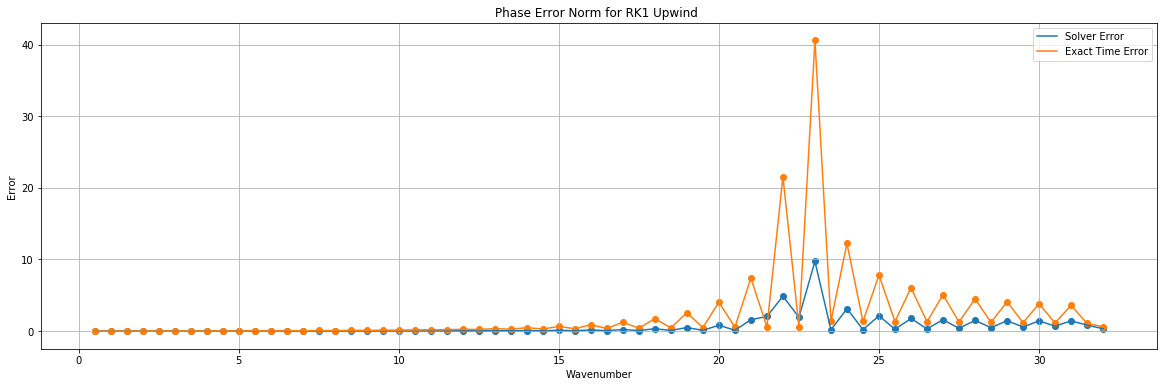

In [11]:
title = 'Phase Error Norm for RK' + str(RK) + title2
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvError, label = 'Solver Error', color = PT.ColorDefault(0))
plt.scatter(ks, solvError, color = PT.ColorDefault(0))
plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
plt.grid(True, zorder = 0)
# plt.ylim(-1, 1.1)
# plt.yscale('log')
plt.show()

In [12]:
ksT, phases = SolverPhaseTheoretical(omega, RK, deriv, CFL)


Upwind 1


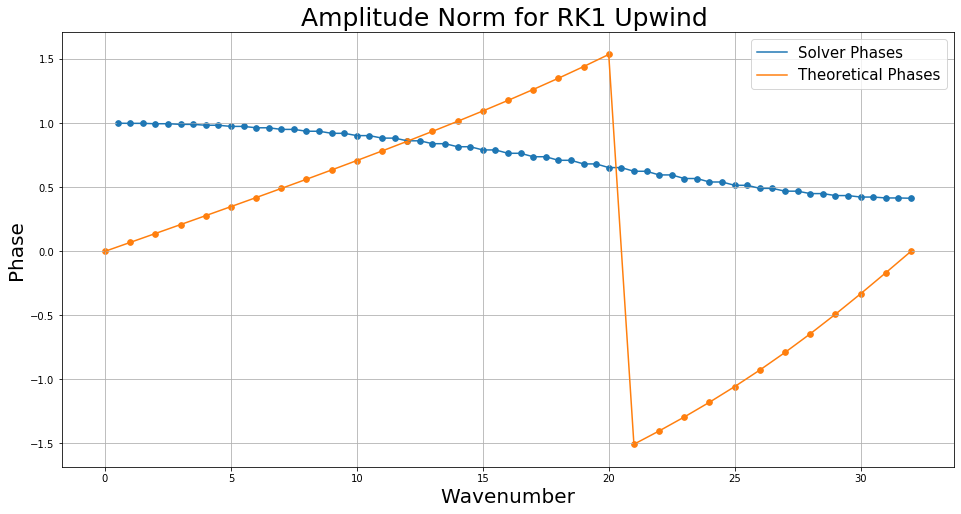

In [13]:
numPoints, font, X, savePath = PT.UsefulPlotVals()
s = 32
saveName = savePath + saveName1 + 'RK' + str(RK) + '.png'
title = title1 + str(RK) + title2
fig, ax = plt.subplots(figsize = [16, 8])
plt.plot(ks, solvNorm, label = 'Solver Phases', color = PT.ColorDefault(0))
plt.scatter(ks, solvNorm, color = PT.ColorDefault(0), s = s)
plt.plot(ksT, phases, label = 'Theoretical Phases', color = PT.ColorDefault(1))
plt.scatter(ksT, phases, color = PT.ColorDefault(1), s = s)
# plt.plot(ksT, np.imag(amps), label = 'Imaginary Amplitudes', color = PT.ColorDefault(2))
# plt.scatter(ksT, np.imag(amps), color = PT.ColorDefault(2))
# plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
# plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title, fontsize = 25)
plt.xlabel('Wavenumber', fontsize = 20)
plt.ylabel('Phase', fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, zorder = 0)
fig.savefig(saveName, bbox_inches = 'tight', dpi = 400, transparent = False)

# plt.ylim(-10, 1000)
# plt.yscale('log')
plt.show()

In [14]:
solvTrunc = np.append(solvNorm[0], solvNorm[1::2])
norm = TT.VectorNorm(solvTrunc - phases, normType = 'L2')
print('Error Norm: ', str(norm))

Error Norm:  5.603249344834631


In [15]:
print(solvError)

[0.00000000e+00 9.01754786e-06 1.95026268e-04 7.58004962e-05 7.81784222e-04 2.69828068e-04 1.76534267e-03 6.77335991e-04 3.15425499e-03 1.40710350e-03 4.96072003e-03 2.59841197e-03 7.20081323e-03 4.43218203e-03 9.89479382e-03 7.14685066e-03 1.30674956e-02 1.10614724e-02 1.67488107e-02 1.66101087e-02 2.09742769e-02 2.43943757e-02 2.57857799e-02 3.52661981e-02 3.12323828e-02 5.04628378e-02 3.73712909e-02 7.18367289e-02 4.42689583e-02 1.02267242e-01 5.20023266e-02 1.46446609e-01 6.06601718e-02 2.12505380e-01 7.03444934e-02 3.15746951e-01 8.11718226e-02 4.88559842e-01 9.32742251e-02 8.12962802e-01 1.06799614e-01 1.57312216e+00 2.03308135e+00 4.86630521e+00 1.91825597e+00 9.72834339e+00 1.62868678e-01 3.12132034e+00 2.01566912e-01 2.12511914e+00 2.48929295e-01 1.75138244e+00 3.06763623e-01 1.57447878e+00 3.77135127e-01 1.48481926e+00 4.62323470e-01 1.44051795e+00 5.64744013e-01 1.42119026e+00 6.86853960e-01 1.41499844e+00 8.31099954e-01 3.16140576e-01]


In [16]:
waves = WT.MakeWaves(omega)
print(waves)

[[ 1.          0.04904797  0.99839439  0.09785976  0.99358685  0.14620071  0.98560515  0.19383918  0.97449536  0.24054802  0.96032155  0.28610607  0.94316532  0.33029951  0.92312528  0.37292323  0.90031632  0.41378216  0.87486887  0.45269244  0.84692799  0.4894826   0.81665238  0.52399458  0.7842133   0.55608469  0.7497934   0.58562448  0.71358549  0.61250146  0.67579123  0.63661977  0.63661977  0.65790063  0.59628638  0.67628278  0.55501094  0.69172273  0.51301654  0.70419489  0.47052798  0.71369162  0.4277703   0.7202231   0.38496727  0.7238171   0.34233999  0.72451862  0.30010544  0.72238945  0.25847508  0.71750755  0.21765354  0.70996639  0.17783732  0.69987414  0.13921362  0.68735278  0.10195915  0.67253711  0.06623912  0.6555737   0.03220627  0.63661977]
 [ 1.          0.14667156  0.98877931  0.28981859  0.95540387  0.42601143  0.90072549  0.55200728  0.82613727  0.66483686  0.73353444  0.76188308  0.62526129  0.84094945  0.5040457   0.90031632  0.37292323  0.9387834   0.235153  

In [17]:
A = np.arange(10)
B = A / A
indices = np.argwhere(np.isnan(B))
B[indices] = 0
print(B)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
